In [8]:
from qiskit import *

## The Deutsch-Jozsa Algorithm
This algorithm solves the problem of determining if a given binary funcion $\{0,1\}^n\rightarrow \{0,1\}$ is balanced or constant. A balanced function is one that has output 1 for precisely half of the input domain.

<!-- There are $2^n$ n-bit functions. Two of these will be constant functions, for outputs 0 and 1. Some of the rest will be balanced. -->

I'll show that the membership of the two classes can be determined using a quantum operation.

### Configurable Oracle

In [9]:
import numpy as np

def build_oracle(balanced:bool, n:int):
    # Generates a balanced or constant oracle for an n-bit binary function
    oracle = QuantumCircuit(n+1,name="Oracle")
    if balanced:
        bits = [np.random.choice([0,1]) for _ in range(n)]
        for qubit_i, bit in enumerate(bits):
            if bit:
                oracle.x(qubit_i)
        for qubit_i, bit in enumerate(bits):
            oracle.cnot(qubit_i, n) 

        for qubit_i, bit in enumerate(bits):
            if bit:
                oracle.x(qubit_i)
    else:
        # constant
        constant_val = np.random.choice([0,1])
        if constant_val == 1:
            oracle.x(n)
    return oracle

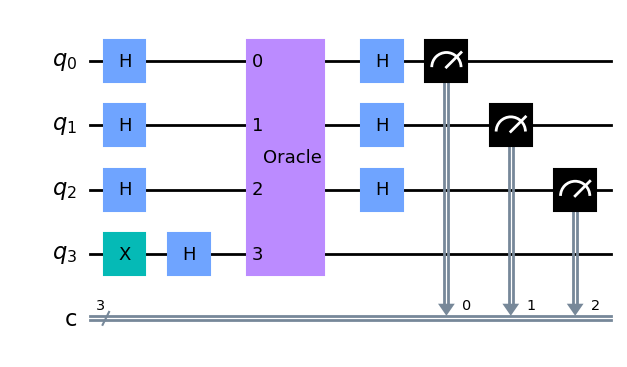

In [10]:
n = int(input("n=...?"))

circuit = QuantumCircuit(n+1,n)
# prepare our initial state: |00> to |01> to |+>|->
circuit.x(n) 
circuit.h(range(n+1))

#Choose an oracle
oracle = build_oracle(balanced=True,n=n).to_instruction()

circuit.append(oracle, range(n+1))

# Hadamard and measure
circuit.h(range(n))
circuit.measure(range(n),range(n))
circuit.draw('mpl')

This operation leaves us in the following state.

$$\frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}\ket{x}(\ket{0 \oplus f(x)}-\ket{1 \oplus f(x)})$$

$f(x)\in \{0,1\}$ for all $x$. 

If $f(x)=0$, we get $\ket{0 \oplus 0}-\ket{1 \oplus 0} = \ket{0}-\ket{1}$. 

If $f(x)=1$, we get $\ket{0 \oplus 1}-\ket{1 \oplus 1} = \ket{1}-\ket{0}$.

We can rewrite this state as $\frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}\ket{x}(\ket{0}-\ket{1})$.

We can ignore the last qubit $\frac{\ket{0}-\ket{1}}{\sqrt{2}}$, to give us 

$$\frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}\ket{x}$$

By applying the Hadamard gate and then measuring, we utilise constructive and destructive interference to choose between constant and balanced respectively.

#### The Hadamard transform
$H^{\otimes n}\ket{k} = \frac{1}{\sqrt{2^n}}\sum_{j=0}^{2^n-1}(-1)^{k \cdot j}\ket{j}$ 

Applying this transform to $x$ we get

$$\frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}\ket{x}\left[  \frac{1}{\sqrt{2^n}}\sum_{y=0}^{2^n-1}(-1)^{x \cdot y}\ket{y}  \right] 
= 
\sum_{y=0}^{2^n-1}\left[\frac{1}{2^n} \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot y}\right]\ket{y} $$

Then for a particular state $k$, the probability for measurement is:

$$ \left| \frac{1}{2^n} \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot k} \right| $$

If we let $k=0$, we get the probability of measurement as:

$$ \left| \frac{1}{2^n} \sum_{x=0}^{2^n-1}(-1)^{f(x)} \right| $$

#### The interference and results

We know that $f(x)$ will be either balanced or constant. Considering these two choices:

Constant: $f(x)$ is either always 0, or always 1. In the 0 case, all the terms in the sum will be $+1$, while in the 1 case, all the terms will be $-1$. Taking the absolute value of this sum gives us $2^n$ which is normalised to give us a measurement probability of 1. This is the constructive interference. 

Balanced: $f(x)$ is always 0 for half of the input domain, and 1 for the other half. This means that destructive interference takes place - for any $+1$ term there is a $-1$ term to cancel it out. This gives us a measurement probability of 0.

So by performing the Hadamard transform and measuring the qubits in $x$, we ascertain in a single operation whether the given function is balanced or constant.

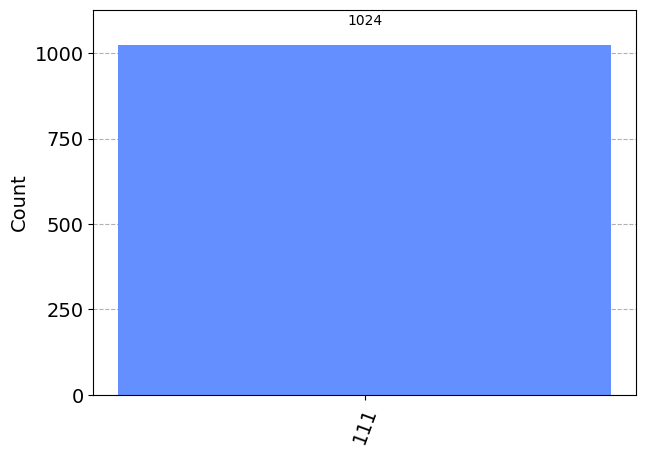

In [11]:
from qiskit.visualization import plot_histogram

backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuit, backend))
counts = job.result().get_counts()
plot_histogram(counts)

Above we can see the 100% measurement probability of $0^{\otimes n}$ for the constant case, and 100% measurement probability of $1^{\otimes n}$ for the balanced case (i.e 0% measurement probability for $0^{\otimes n}$)